### Initiation

In [84]:
# To manipulate arrays
import numpy as np 
# To import images 

# To handle track DataFrames
import pandas as pd

# To import images
from skimage import io 
from skimage.io import imread

# For TrackPy
import trackpy as tp

# To make plots
import matplotlib as mpl 
import matplotlib.pyplot as plt 
import seaborn as sns; sns.set()  

# To work inline; change to %matplotlib notebook for interactive plotting
%matplotlib inline 

# Napari 
%gui qt5 
from skimage import data
import napari

# To create interactive elements
import ipywidgets as widgets 
from ipywidgets import interact, interactive, fixed, interact_manual, Button, HBox, VBox, Layout, GridspecLayout
from ipywidgets.embed import embed_minimal_html, dependency_state

# Image processing and filters
from skimage.filters import difference_of_gaussians

# Iteration tools such as groupby 
import itertools

# For directories 
import os

# For reloading a library when testing
import importlib

# For deleting/reloading modules in another file for code testing
import sys

# For statistics
from scipy import stats

# For curve fitting
from scipy.optimize import curve_fit

# Seaborn plotting
import seaborn as sns

# Import trackArrayTools
from trackArrayTools import *

#rSNAPsim_IP
cwd = os.getcwd()  # get current working director
os.chdir('../rSNAPsim_IP/rSNAPsim_IP/') # assume rSNAPsim_IP is  one directory up
import rSNAPsim_IP as rss_IP #importing rSNAPsim.
os.chdir(cwd) # change back to original current directory (the directory this file is in)

#del sys.modules['trackArrayTools']  # Use this if you are coding new class methods and want to reread trackArrayTools.py file
#from trackArrayTools import *

FileNotFoundError: [WinError 3] The system cannot find the path specified: '../rSNAPsim_IP/rSNAPsim_IP/'

In [85]:
#os.chdir('C:/Users/tim_s/OneDrive - Colostate/Stasevich Lab/Lab Management/Dry Lab/Python/Python Scripts/LabScripts')

### Set current working directory, track array filenames, and basic parameters

In [86]:
# Enter in the following:
crop_pad = 5    # specifies the size of crops in track arary. If 5, then crops are (2*5 + 1 = 11) x 11
xy_pixel_size = 130   # voxel  xy dimensions in crops
z_pixel_size = 500   # voxel z dimension
working_directory = 'C:/Users/tim_s/Documents/Python Scripts/LabScripts/TestData/'
video_3D_filename_path = 'C:/Users/tim_s/Documents/Python Scripts/LabScripts/TestData/'
beads_path ='X:/_FiXie/Manders/20181022_EMCV_NT_Chamber1/Beads/'
video_3D_filename = 'TA06_har.tif'

In [87]:
# For display, so z and xy are shown properly when viewing track array
z_renorm = z_pixel_size/xy_pixel_size  

#  Track array filenames should be the following:
track_array_filename = 'Particles_' + video_3D_filename[:-4] + '_crop_pad_' + str(crop_pad) + '.tif' 
track_filename = track_array_filename[:-15] + '.csv'
[track_array_filename, track_filename]

['Particles_TA06_har_crop_pad_5.tif', 'Particles_TA06_har.csv']

### Creating Track Array (only done once using original 3D video and tracks)

In [ ]:
# Loading the figure with beads so track array can be registered
# Dimension 1 is the number of channel. Red and Green. # Dimension 2 is the x axis. # Dimension 3 is the y axis.
figWithBeads = beads_path + 'Beads04.tif'
im_beads = io.imread(figWithBeads) # reading the image

In [ ]:
# Using rSNAPSim to get the homography matrix to align the green/blue channels with red
temp_obj_beads = rss_IP.BeadsAlignment(im_beads)
[my_homography,positions_green,positions_red] = temp_obj_beads.make_beads_alignment()  # !!! Adjusted Luis' code to spit this info out

In [ ]:
# Check that the homography matrix is working:
my_homography_inverse = np.linalg.inv(my_homography)  # This is the transformation we use to shift green to red
print('[original distance, corrected distance (shift red to green), corrected distance (shift green to red)]' )
for i in np.arange(len(positions_green)):
    g0=positions_green[i]
    g=np.dot(my_homography_inverse,[positions_green[i,0],positions_green[i,1],1])[0:2]  # Correct green/blue
    r0=positions_red[i]
    r=np.dot(my_homography,[positions_red[i,0],positions_red[i,1],1])[0:2]  # What you'll do: shift red to green
    print([np.linalg.norm(g0-r0),np.linalg.norm(g0-r),np.linalg.norm(g-r0)]) # Check corrections

In [ ]:
# Read in the original 3D video 
video_3D = imread(video_3D_filename_path+video_3D_filename)

In [ ]:
# Create track array tif video from the original 3D video
# This only needs to be done once. Thereafter, can skip and just work with track array itself
video_3D = imread(video_3D_filename_path + video_3D_filename)
dims = list(video_3D.shape)
if len(dims) == 4:     # check if just a single channel video
    n_channels = 1
    n_frames, z_slices, height_y, width_x = dims
else:
    n_channels = min(dims)
    n_channels_index = dims.index(n_channels)   # find index of n_channels, which is assumed to be smallest dimension 
    dims.remove(n_channels)    
    video_3D = np.moveaxis(video_3D,n_channels_index,-1)  # move channels to last dimension of array (assumed by napari)
    n_frames, z_slices, height_y, width_x = dims

In [ ]:
# Read in the tracking file that corresponds to the original 3D video
tracks = pd.read_csv(video_3D_filename_path+track_filename) 
tracks.head()

In [ ]:
viewer = napari.Viewer()
viewer.add_image(video_3D[:,:,:,:,0],name='red',blending="additive", scale=[z_renorm,1,1])
particles = tracks[['POSITION_T','POSITION_Z','POSITION_Y','POSITION_X']].values
viewer.add_points(particles, size=5, opacity = 0.3,
                edge_color = 'yellow',
                  face_color = 'yellow', symbol='ring')

In [ ]:
create_particle_array_video(working_directory, track_array_filename, video_3D, 
                             tracks, crop_pad, xy_pixel_size, z_pixel_size, homography = my_homography)
# create_track_array_video(working_directory, track_array_filename, video_3D[0::10], tracks, crop_pad, xy_pixel_size, z_pixel_size)

### Track Array analysis one-by-one: best-z projection + 2D background subtract

In [ ]:
# Just in case you want to update trackArrayTools without having to restart Kernel
#del sys.modules['trackArrayTools']  # Use this if you are coding new class methods and want to reread trackArrayTools.py file
#from trackArrayTools import *

# Choose which track array you want to work with:
working_directory ='C:/Users/tim_s/Documents/Python Scripts/LabScripts/TestData/Harringtonine/'
track_array_filename ='Particles_TL01harb_crop_pad_5.tif'

# The corresponding tracking file should be in the same directory and have the following filename: 
track_filename = track_array_filename[:-15] + '.csv'

# Read in the track array video 
track_array_vid = imread(working_directory + track_array_filename)  # Read in track array .tif file

# Read in tracks as a "dataframes (df)"
track_array_df = pd.read_csv(working_directory + track_filename)

# Make sure color channels are the last dimension of the track array
dims = list(track_array_vid.shape)
if len(dims) != 3:     # check if just a single channel video
    n_channels = min(dims)
    n_channels_index = dims.index(n_channels)
    track_array_vid = np.moveaxis(track_array_vid,n_channels_index,-1)

In [ ]:
# Step 0: Create the track array object:
#del sys.modules['trackArrayTools']  # Use this if you are coding new class methods and want to reread trackArrayTools.py file
#from trackArrayTools import *
ta = TrackArray(track_array_vid, track_array_df, crop_pad)

In [ ]:
# Step 0.5: check if z's are offset in different channels
my_offset = [0,-1,-1]  ### For 3-color, could be [0,-1,-1]; BE CAREFUL, THIS WILL MAKE A MASK THAT IS SHIFTED IN Z FOR BLUE AND GREEN!!!
capsule_mask = ta.capsule_mask(crop_pad,crop_pad,2,1,0,z_offset=my_offset)
arr_bg = ta.local_background_subtract(ta.arr,capsule_mask)

# Check with napari
max = np.max(arr_bg,axis=(0,1,2)) # find max intensities for setting intensity range
my_range = [[0,max[ch]] for ch in np.arange(len(max))]
napari_viewer(arr_bg,[z_renorm,1,1],int_range=my_range,layer=[capsule_mask[:,:,:,0],capsule_mask[:,:,:,1]])

In [ ]:
# Step 1: Best-z projection using offset from above
my_best_z_masks = ta.best_z_mask(1,0,z_offset = my_offset) # best-z mask w/ offset
best_z = ta.mask_projection(np.clip(ta.arr,0,1000000), my_best_z_masks) # best-z projection; clip to make sure data is +

# Check with napari
max = np.max(best_z,axis=(0,1)) # find max intensities for setting intensity range
my_range = [[0,max[ch]] for ch in np.arange(len(max))]
napari_viewer(best_z,[1,1],int_range=my_range)

In [ ]:
# Step 2: Subtract background in donut rings from max projection  
best_z_bg = ta.local_background_subtract(best_z,ta.donut_mask_2D(5,1))

# Check with napari and show donut mask
max = np.max(best_z_bg,axis=(0,1)) # find max intensities for setting intensity range
my_range = [[0,max[ch]] for ch in np.arange(len(max))]
napari_viewer(best_z_bg,[1,1],int_range=my_range,layer=[ta.donut_mask_2D(5,1)])

In [ ]:
# Output background-subtracted and max-z projected track array 
output_filename_path = working_directory + track_array_filename[0:-4] + '_bestz_bg-sub.tif'
io.imsave(output_filename_path,
        best_z_bg, 
        resolution=(1/xy_pixel_size,1/xy_pixel_size))
output_filename_path

### Track Array analysis loop: best-z projection + 2D background subtract

In [ ]:
# Loop everything above on a collection of images, if desired. 
working_directory = 'C:/Users/tim_s/Documents/Python Scripts/LabScripts/TestData/Harringtonine/'
vids_TA =['TA01har.tif','TA02har.tif','TA03har.tif','TA04har.tif','TA04_har.tif','TA06_har_bot.tif'
          ,'TA06_har_top.tif','TA06har.tif','TA07har.tif','TA08har.tif','TA09har.tif','TA11har.tif','TA12har.tif',
          'TA13har.tif','TA14har.tif','TA16har.tif','TA17har.tif','TA18har.tif','TA20har.tif'] 
vids_TL =['TL01har.tif','TL01harb.tif','TL02har.tif','TL02harc.tif','TL03har.tif','TL03hara.tif',
          'TL03harc.tif','TL04har.tif','TL04harb.tif','TL04harc.tif','TL05har.tif','TL05harb.tif','TL05harc.tif',
          'TL06harc.tif','TL07harc.tif','TL12har.tif','TL13har.tif','TL14har.tif']  
vids_NT=['NT01har.tif','NT02har.tif','NT03har.tif','NT04har.tif','NT05har.tif']

# Choose a set of videos to loop through
vids = vids_TL
my_offset = [0,-1,-1]  ### BE CAREFUL, THIS WILL MAKE A MASK THAT IS SHIFTED IN Z FOR BLUE AND GREEN!!!
for vs in vids:
    # Get track array video and tracking files:
    track_array_filename = 'Particles_'+vs[0:-4]+'_crop_pad_5.tif'
    track_filename = track_array_filename[:-15] + '.csv'

    # Read in the track array video 
    track_array_vid = imread(working_directory + track_array_filename)  # Read in track array .tif file

    # Read in tracks as a "dataframes (df)"
    track_array_df = pd.read_csv(working_directory + track_filename)

    # Make sure color channels are the last dimension of the track array
    dims = list(track_array_vid.shape)
    if len(dims) != 3:     # check if just a single channel video
        n_channels = min(dims)
        n_channels_index = dims.index(n_channels)
        track_array_vid = np.moveaxis(track_array_vid,n_channels_index,-1)

    # Step 0: make the track array object
    ta = TrackArray(track_array_vid, track_array_df, crop_pad)
    
    # Step 1: Now do best-z projection with offset
    my_best_z_masks = ta.best_z_mask(1,0,z_offset = my_offset) # this part is same as above
    best_z = ta.mask_projection(np.clip(ta.arr,0,1000000), my_best_z_masks) # best-z projection; clip to make sure data is +
    
    # Step 2: Subtract background in donut rings from max projection  
    best_z_bg = ta.local_background_subtract(best_z,ta.donut_mask_2D(5,1))

    # Output background-subtracted and max-z projected track array 
    output_filename_path = working_directory + track_array_filename[0:-4] + '_bestz_bg-sub.tif'
    io.imsave(output_filename_path,
            best_z_bg, 
            resolution=(1/xy_pixel_size,1/xy_pixel_size))
    
output_filename_path


### Combining track arrays together for global analysis

In [32]:
# del sys.modules['trackArrayTools']  # Use this if you are coding new class methods and want to reread trackArrayTools.py file
# from trackArrayTools import *

In [88]:
# Specify basic track array parameters (in case not done above)
crop_pad = 5    # specifies the size of crops in track arary. If 5, then crops are (2*5 + 1 = 11) x 11
xy_pixel_size = 130   # voxel  xy dimensions in crops
z_pixel_size = 500   # voxel z dimension

# Specify working directory and files you want to read in:
working_directory ='C:/Users/tim_s/Documents/Python Scripts/LabScripts/TestData/Harringtonine/'

# full file listing
vids_TA =['TA01har.tif','TA02har.tif','TA03har.tif','TA04har.tif','TA04_har.tif','TA06_har_bot.tif','TA06_har_top.tif',
          'TA06har.tif','TA07har.tif','TA08har.tif','TA09har.tif','TA11har.tif','TA12har.tif','TA13har.tif','TA14har.tif',
          'TA16har.tif','TA17har.tif','TA18har.tif','TA20har.tif'] 
vids_TL =['TL01har.tif','TL01harb.tif','TL02har.tif','TL02harc.tif','TL03har.tif','TL03hara.tif','TL03harc.tif',
          'TL04har.tif','TL04harb.tif','TL04harc.tif','TL05har.tif','TL05harb.tif','TL05harc.tif','TL06harc.tif','TL07harc.tif',
          'TL12har.tif','TL13har.tif','TL14har.tif']  
vids_NT=['NT01har.tif','NT02har.tif','NT03har.tif','NT04har.tif','NT05har.tif']

# A list of which replicate each vid above corresponds to :
replicates_TA = [1,1,1,1,3,3,3,1,1,1,1,2,2,2,2,2,2,2,2]
replicates_TL = [1,3,1,3,1,3,3,1,3,3,1,3,3,3,3,2,2,2]  #[1,3,1,4,1,3,4,1,3,4,1,3,4,4,4,2,2]
replicates_NT = [1,1,1,1,1]

# A list of expt. names:
my_expts = ('Ago2', '\u03B2-gal','NT')

# The name of the 2D bg-subtracted crop array vids
track_array_filenames_TA = ['Particles_' + videos[:-4] + '_crop_pad_' + 
                          str(crop_pad) + '_bestz_bg-sub.tif' for videos in vids_TA]
track_array_filenames_TL = ['Particles_' + videos[:-4] + '_crop_pad_' + 
                           str(crop_pad) + '_bestz_bg-sub.tif' for videos in vids_TL]
track_array_filenames_NT = ['Particles_' + videos[:-4] + '_crop_pad_' + 
                           str(crop_pad) + '_bestz_bg-sub.tif' for videos in vids_NT]

In [89]:
# Read in all track array videos and corresponding tracking files:
track_array_vids_TA = [imread(working_directory + i) for i in track_array_filenames_TA]  # Read in track array .tif file
track_files_TA = [pd.read_csv(working_directory + 'Particles_' + videos[:-4]+'.csv') 
                  for videos in vids_TA] 

# add 'File' column to dataframes to keep track of which row in the track array comes from which file
for i in np.arange(len(track_files_TA)):
    track_files_TA[i]['File'] =  ('Particles_' + vids_TA[i][:-4]+'.csv')

# repeat for other experiments (TL and NT):
track_array_vids_TL = [imread(working_directory + i) for i in track_array_filenames_TL]  # Read in track array .tif file
track_files_TL = [pd.read_csv(working_directory + 'Particles_' + videos[:-4]+'.csv') 
                  for videos in vids_TL] 

for i in np.arange(len(track_files_TL)):
    track_files_TL[i]['File'] =  ('Particles_' + vids_TL[i][:-4]+'.csv')
    
track_array_vids_NT = [imread(working_directory + i) for i in track_array_filenames_NT]  # Read in track array .tif file
track_files_NT = [pd.read_csv(working_directory + 'Particles_' + videos[:-4]+'.csv') 
                  for videos in vids_NT] 

for i in np.arange(len(track_files_NT)):
    track_files_NT[i]['File'] =  ('Particles_' + vids_NT[i][:-4]+'.csv')

# Make individual track arrays, so can check one-by-one:
tas = [TrackArray(np.array([track_array_vids_TA[i]]), track_files_TA[i], crop_pad) 
       for i in np.arange(len(track_array_vids_TA))]
tls = [TrackArray(np.array([track_array_vids_TL[i]]), track_files_TL[i], crop_pad) 
       for i in np.arange(len(track_array_vids_TL))]
nts = [TrackArray(np.array([track_array_vids_NT[i]]), track_files_NT[i], crop_pad) 
       for i in np.arange(len(track_array_vids_NT))]

In [90]:
#View the background-subtracted track array and disk mask to measure intensities in:
myn=2
arrs = nts
napari_viewer(arrs[myn].arr,[1,1],int_range=[[0,10000] for i in np.arange(arrs[myn].n_channels())],
             layer=[arrs[myn].donut_mask_2D(5,1),arrs[myn].disk_mask_2D(3)])

### Global Analysis

In [91]:
# Choose working directory where you want to save figures and data:
os.chdir('C:/Users/tim_s/OneDrive - Colostate/Stasevich Lab/Our papers/Ago2Tethering/TimHarringtonineAnalysis/Plots/')

In [92]:
# Make dataframes from the measurements of intensities in 2D disk masks:
chs = ['mRNA Int. (a.u.)', 'Trnl. Int. (a.u.)', 'Tether Int. (a.u.)']
rchs = ['Renorm. '+ c for c in chs]

#The photobleach corrections for each replicate.Found by quantifying total fluroescence decay vs. time.
k_pbs = [[0.0011,0.00079,0.00078], # rep 1
         [0.00074,0.00090,0.00047], # rep 2
         [0.00090,0.0013,0.0018]] # rep 3

df_tas = [tas[i].measure_intensity_in_mask_df(tas[i].arr, np.array([tas[i].disk_mask_2D(3)]), dt=1, 
            start_frame=5, renorm_frames=[0,7], file=vids_TA[i], ch_names = chs, replicate=replicates_TA[i], 
            exp=my_expts[0], k_pb=k_pbs[replicates_TA[i]-1]) for i in np.arange(len(tas))]
df_tls = [tls[i].measure_intensity_in_mask_df(tls[i].arr, np.array([tls[i].disk_mask_2D(3)]), dt=1, 
            start_frame=5, renorm_frames=[0,7], file=vids_TL[i], ch_names = chs, replicate=replicates_TL[i], 
            exp=my_expts[1], k_pb=k_pbs[replicates_TA[i]-1]) for i in np.arange(len(tls))]
df_nts = [nts[i].measure_intensity_in_mask_df(nts[i].arr, np.array([nts[i].disk_mask_2D(3)]), dt=1, 
            start_frame=5, renorm_frames=[0,7], file=vids_NT[i], ch_names = chs, replicate=replicates_NT[i], 
            exp=my_expts[2], k_pb=k_pbs[replicates_TA[i]-1]) for i in np.arange(len(nts))]

In [96]:
# Concatenate everything together:
df_ta = pd.concat(df_tas, axis=0, sort=False) 
df_tl = pd.concat(df_tls, axis=0, sort=False) 
df_nt = pd.concat(df_nts, axis=0, sort=False)
df_all = pd.concat([df_ta,df_tl,df_nt], axis = 0, sort=False)
df_all.to_csv('Harringtonine-data.csv')
df_all.head()

,Crop Row,Frame,Original time (min),Time (min),mRNA Int. (a.u.),Trnl. Int. (a.u.),Tether Int. (a.u.),Renorm. mRNA Int. (a.u.),Renorm. Trnl. Int. (a.u.),Renorm. Tether Int. (a.u.),% Change mRNA Int. (a.u.),% Change Trnl. Int. (a.u.),% Change Tether Int. (a.u.),Expt.,Rep.,File
0,0.0,0.0,0.0,-5.0,249.071162,-42.533385,-23.243656,0.739428,-0.449914,-0.189430,0.001467,-0.000394,-0.000610,Ago2,1,TA01har.tif
1,0.0,1.0,1.0,-4.0,288.303669,1144.394373,83.450435,0.855899,12.105284,0.680102,0.001696,0.010580,0.002188,Ago2,1,TA01har.tif
2,0.0,2.0,2.0,-3.0,428.702772,1451.626255,65.653088,1.272707,15.355151,0.535057,0.002520,0.013410,0.001720,Ago2,1,TA01har.tif
3,0.0,3.0,3.0,-2.0,400.883465,1529.330885,57.666005,1.190119,16.177102,0.469965,0.002354,0.014117,0.001510,Ago2,1,TA01har.tif
4,0.0,4.0,4.0,-1.0,176.909603,-63.522211,13.803023,0.525199,-0.671931,0.112491,0.001038,-0.000586,0.000361,Ago2,1,TA01har.tif


In [97]:
df_all[(df_all['Crop Row']==0) & (df_all['Time (min)']>5)]['Trnl. Int. (a.u.)'].values

array([ -20.30636926, 1227.82717931, -127.4633731 , ...,    7.96452536,
        -70.27641685,   93.71301661])

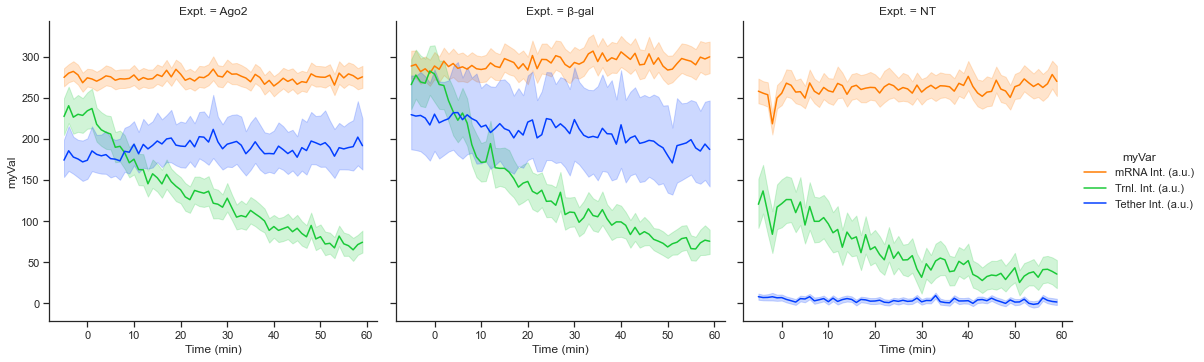

In [12]:
# Basic settings for all subsequent plots:
sns.set(font="Arial")
sns.set_style("white")
sns.set_style('ticks')
# melt dataframe to plot multiple columns (y-vals) vs a single column (x-vals):
df_temp=pd.melt(df_all, id_vars=['Time (min)','Expt.','Rep.'],var_name='myVar', value_name='myVal',
    value_vars=chs)

# Choose palette, plot, and save:
my_palette = [sns.color_palette("bright")[1],sns.color_palette("bright")[2],
              sns.color_palette("bright")[0]]
g=sns.relplot(x='Time (min)', y='myVal', hue='myVar', col='Expt.',data = df_temp, kind='line',
            palette=my_palette,legend=True,aspect=1)
plt.savefig('Harringtonine-AvgAll-3-color.svg', format = 'svg', dpi=300)

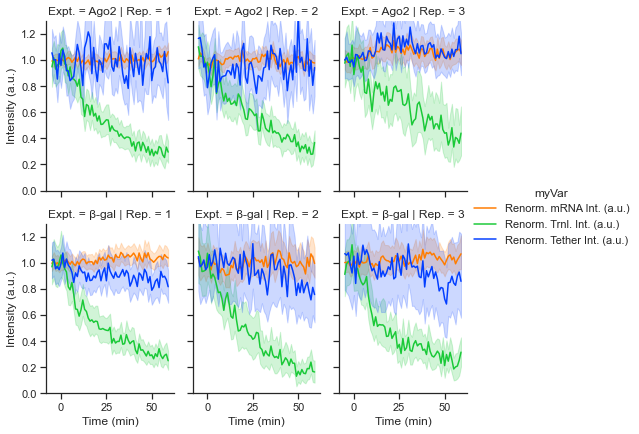

In [13]:
# melt dataframe to plot multiple columns (y-vals) vs a single column (x-vals):
df_temp=pd.melt(df_all[df_all['Expt.']!='NT'], id_vars=['Time (min)','Expt.','Rep.'],var_name='myVar', 
                value_name='Intensity (a.u.)',value_vars=rchs)

# Display all replicates for Ago2 tethering (top row) and LacZ tethering (bottom row)
my_palette = [sns.color_palette("bright")[1],sns.color_palette("bright")[2],sns.color_palette("bright")[0]]
g=sns.relplot(x="Time (min)", y="Intensity (a.u.)",col="Rep.",hue="myVar", row="Expt.",kind='line', 
            data=df_temp, palette=my_palette,legend=True,height=3, aspect=.75)
g.set(ylim=(0., 1.3))
plt.savefig('Harringtonine-Replicates.svg', format = 'svg', dpi=300)

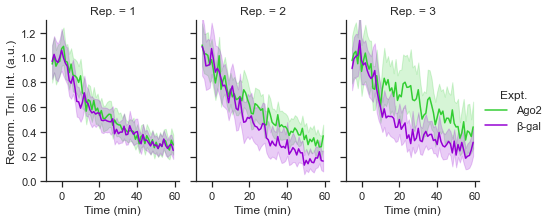

In [110]:
sns.set_style('ticks')
# Compare Ago2 tethering (blue) to lacZ tethering (orange) in replicates
my_palette =['limegreen','darkviolet']
g=sns.relplot(x="Time (min)", y=rchs[1],col="Rep.",hue="Expt.", kind='line', 
            data=df_all[(df_all['Expt.']!='NT')], palette=my_palette,legend=True,height=3, aspect=.75)
g.set(ylim=(0, 1.3))
plt.savefig('Harringtonine-ReplicatesV2.svg', format = 'svg', dpi=300)

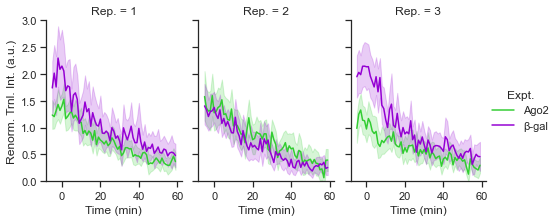

In [109]:
sns.set_style('ticks')
# Compare Ago2 tethering (blue) to lacZ tethering (orange) in replicates
my_palette =['limegreen','darkviolet']
g=sns.relplot(x="Time (min)", y=rchs[1],col="Rep.",hue="Expt.", kind='line', 
            data=df_all[(df_all[chs[2]]>=200)&(df_all['Expt.']!='NT')], palette=my_palette,legend=True,height=3, aspect=.75)
g.set(ylim=(0, 3))

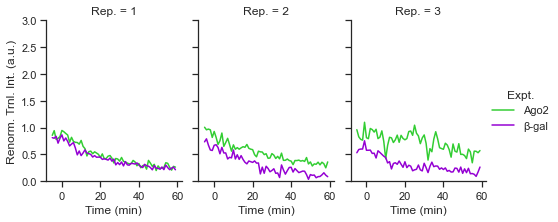

In [107]:
# Compare Ago2 tethering (blue) to lacZ tethering (orange) in replicates
my_palette =['limegreen','darkviolet']
g=sns.relplot(x="Time (min)", y=rchs[1],col="Rep.",hue="Expt.", kind='line', 
            data=df_all[(df_all[chs[2]]<200)&(df_all['Expt.']!='NT')], palette=my_palette,legend=True,height=3, aspect=.75,ci=None)
g.set(ylim=(0, 3))

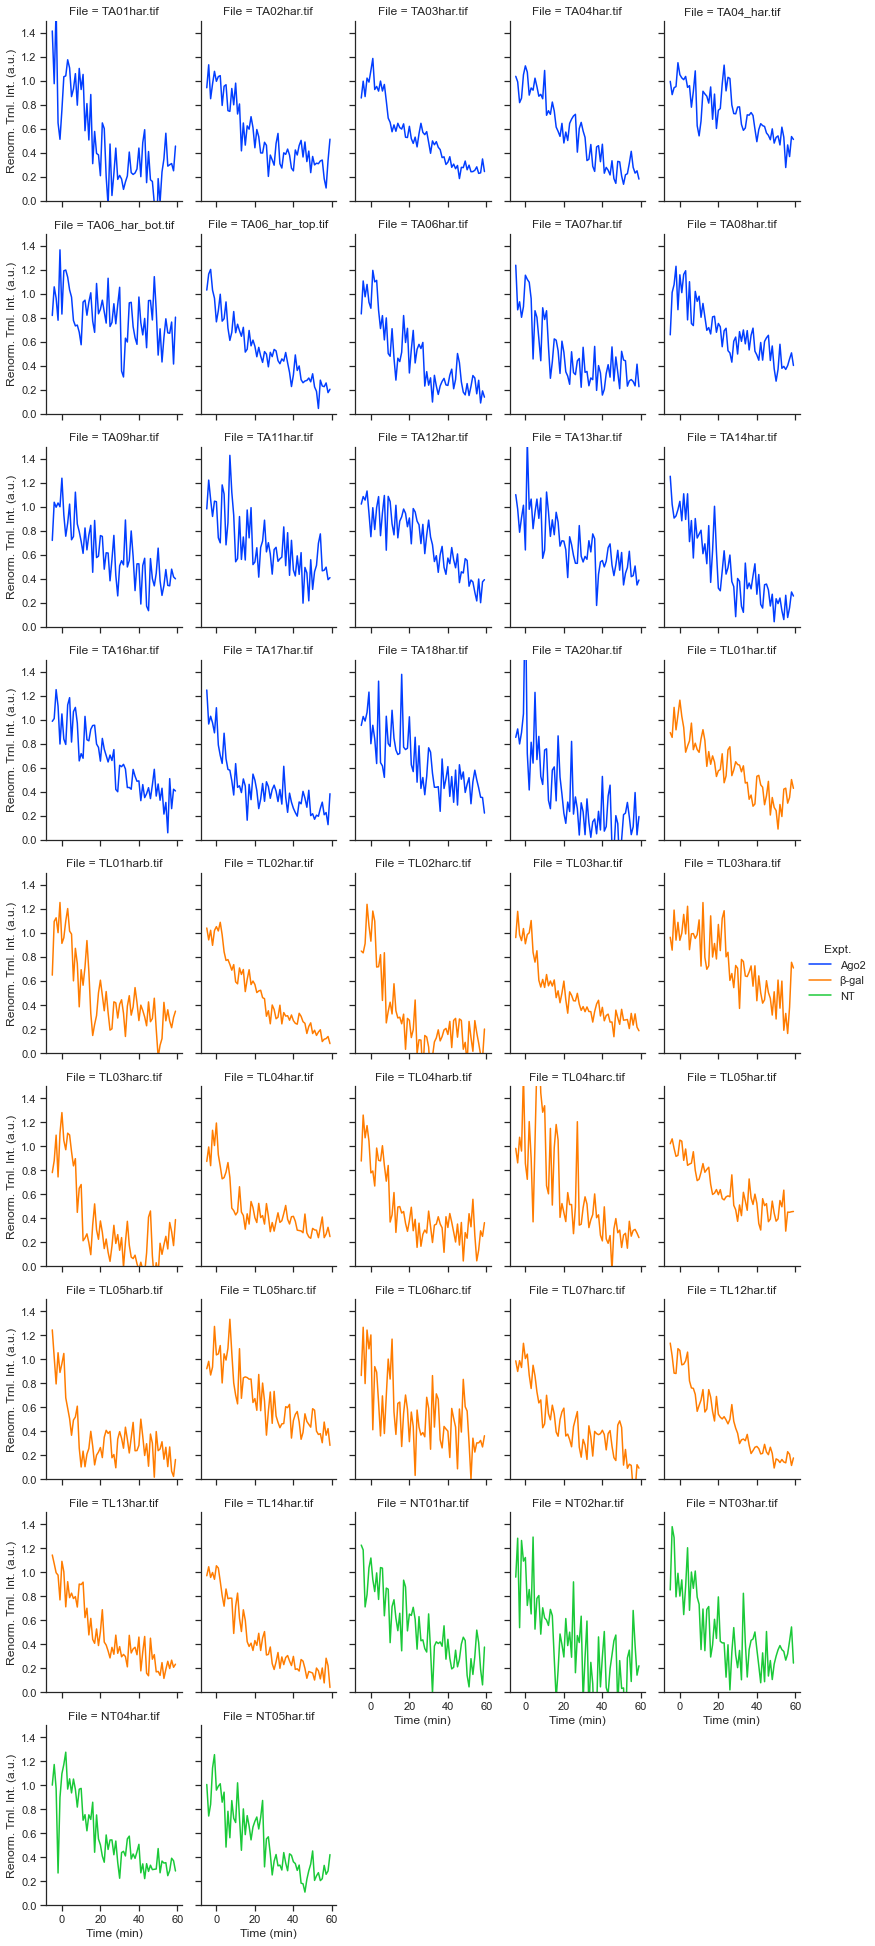

In [15]:
# Display all cells one-by-one. 1-19 Ago2; 100-1700 LacZ
g=sns.relplot(x="Time (min)", y=rchs[1],hue="Expt.",col="File", kind='line', 
            data=df_all, palette='bright',legend=True,col_wrap=5,
              height=3, aspect=.75,ci=None)
g.set(ylim=(0, 1.5))

### Fitting data w/ model for run-off

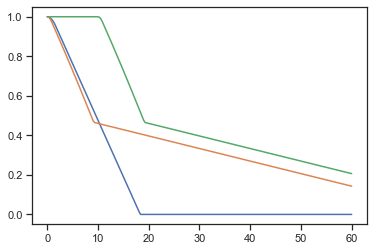

In [113]:
# Bertrand's function for fitting run-off with a single run-off rate v1:
def harringtonine(t, L1, L2, v):
    conds = [t <= 0, (t>0) & (t < L1/v), (t >= L1/v) & (t < (L1+L2)/v), t >= (L1+L2)/v]
    funcs =  [  lambda t:  1,
                lambda t:  (1/(L1+2*L2))*(  (1-(v*t/L1)*(v*t/L1))*L1 + 2*L2  ), 
                lambda t: ( 1 - (v/L2)*(t-L1/v) )*(2*L2/(L1+2*L2)),
                lambda t: 0  ]
    return np.piecewise(t, conds, funcs)

# A two-state run-off, with two avg. elongation rates, v1 and v2:
def harringtonine_2state(t, L1,L2,v1,v2,f1):
        return f1*harringtonine(t,L1,L2,v1) + (1-f1)*harringtonine(t,L1,L2,v2)
def harringtonine_2state_offset(t, L1,L2,v1,v2,f1,t0):
        return f1*harringtonine(t-t0,L1,L2,v1) + (1-f1)*harringtonine(t-t0,L1,L2,v2)
tt = np.linspace(0, 60, 200)
plt.plot(tt, harringtonine(tt, 150, 1500, 90))
plt.plot(tt, harringtonine_2state(tt, 150, 1500, 180, 20, 0.5))
plt.plot(tt, harringtonine_2state_offset(tt, 150, 1500, 180, 20, 0.5, 10))
plt.show() # or plt.savefig('foo.eps')

In [114]:
# Fit all the data to the two-state Harringtonine run-off model:
sns.set_style('ticks')

# Function to fit, plugging in values for tag lengths
def myf(t,v1,v2,f):
    return harringtonine_2state(t,336,1549,v1,v2,f)  # Spaghetti monster tag = 336 aa; KDM5B = 1549 aa 

# Define some columns for the data frame to keep track of expt., rep, and file:
my_files = vids_TA+vids_TL+vids_NT
expt_list = [my_expts[0]]*len(df_ta['File'].unique()) + [my_expts[1]]*len(df_tl['File'].unique()) + [my_expts[2]]*len(df_nt['File'].unique())# Expt. list]
rep_list = replicates_TA+replicates_TL+replicates_NT  # Join replicate lists

# Make an empty numpy array to hold all the fits:
fit_data = np.zeros([len(my_files),3])

# Loop through the data
for i in np.arange(len(my_files)):


    # Choose the appropriate data for each file
    temp_data =df_all[(df_all['File']==my_files[i]) &
          (df_all['Time (min)']>=0)].groupby('Time (min)').agg('mean')[rchs[1]]
    x_vals = temp_data.index                      
    y_vals = temp_data.values

    # Fit the datam to the function
    pars, cov = curve_fit(f=myf, xdata=x_vals, ydata=y_vals, p0=[180, 20, 0.5], bounds=(0, np.inf), maxfev=2000)

    # Fill the array with info to keep track of expt., rep, and file: 
    fit_data[i,0:2]= pars[0:2]/60  # convert elongation rates from aa/min to aa/sec
    fit_data[i,2] = pars[2]    
    df_fit = pd.DataFrame(fit_data, columns=['Fast elong. rate (aa/sec)', 
                                          'Slow elong. rate (aa/sec)', 'Fast fraction'])

# Make the dataframe    
df_fits = pd.DataFrame(fit_data, columns=['Fast elong. rate (aa/sec)', 
                                          'Slow elong. rate (aa/sec)', 'Fast fraction'])
df_fits['Expt.'] = expt_list
df_fits['Rep.'] = rep_list
df_fits['File'] = my_files     

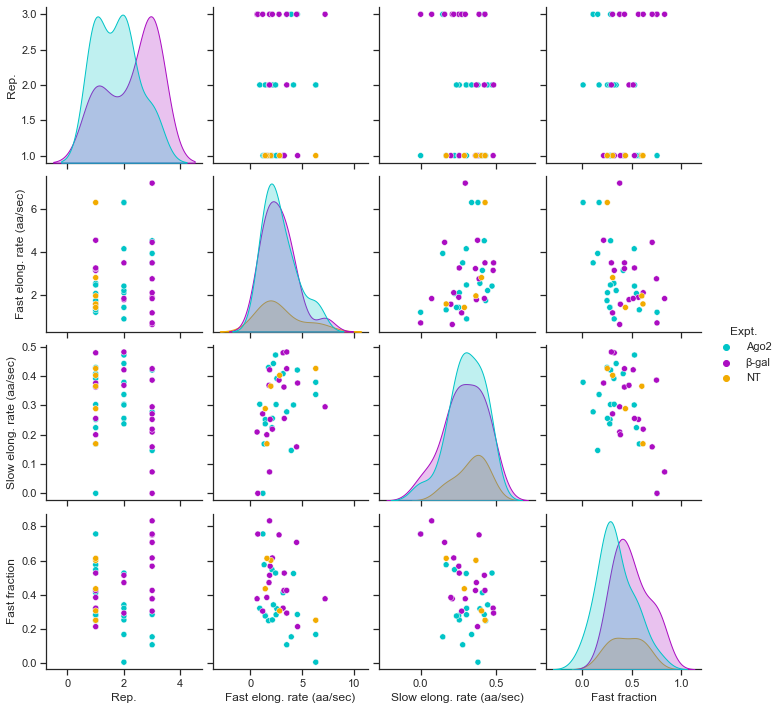

In [115]:
# Plot it all
g = sns.pairplot(df_fits,vars=['Rep.','Fast elong. rate (aa/sec)','Slow elong. rate (aa/sec)',
            'Fast fraction'], hue="Expt.", palette=[(0,0.77,0.78),(.67,.05,.76),(.95,.67,0)], 
                 diag_kind="kde", height=2.5)

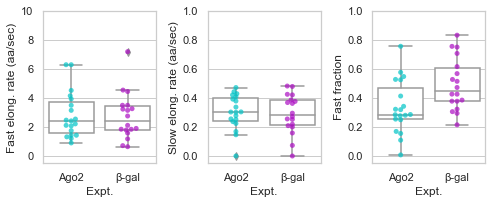

In [138]:
sns.set_style("whitegrid")
fig = plt.figure(figsize=(7, 3))
gs = fig.add_gridspec(1, 3)
ax = fig.add_subplot(gs[0, 0])
g1 = sns.boxplot(x='Expt.',y='Fast elong. rate (aa/sec)', data=df_fits[df_fits['Expt.']!='NT'],
                    palette=['white','white'])
sns.swarmplot(x='Expt.', y='Fast elong. rate (aa/sec)', data=df_fits[df_fits['Expt.']!='NT'],
             palette=[(0,0.77,0.78),(.67,.05,.76)], alpha=0.7) 
g1.set(ylim=(-.5, 10))
ax = fig.add_subplot(gs[0, 1])
g1=sns.boxplot(x='Expt.',y='Slow elong. rate (aa/sec)', data=df_fits[df_fits['Expt.']!='NT'],
                  palette=['white','white'])
sns.swarmplot(x='Expt.', y='Slow elong. rate (aa/sec)', data=df_fits[df_fits['Expt.']!='NT'], 
              palette=[(0,0.77,0.78),(.67,.05,.76)], alpha=0.7) 
g1.set(ylim=(-.05, 1))
ax = fig.add_subplot(gs[0, 2])
g1=sns.boxplot(x='Expt.',y='Fast fraction', data=df_fits[df_fits['Expt.']!='NT'],
               palette=['white','white'])
g1=sns.swarmplot(x='Expt.', y='Fast fraction', data=df_fits[df_fits['Expt.']!='NT'], 
                 palette=[(0,0.77,0.78),(.67,.05,.76)],alpha=0.7) 
g1.set(ylim=(-.05, 1))
fig.tight_layout()
plt.savefig('Harringtonine-BoxPlots.svg', format = 'svg', dpi=300)
plt.show()
df_fits.to_excel("HarringtonineFits-Ago2.xlsx") 

In [116]:
# Check stats of fitted parameters:
fit_stats_df = df_fits.groupby('Expt.').agg(['mean','std',
                       'median','min','max'])[['Fast elong. rate (aa/sec)','Slow elong. rate (aa/sec)','Fast fraction']]
df_fits.to_excel("HarringtonineFits-Stats.xlsx") 

In [117]:
from scipy.stats import mannwhitneyu
[
mannwhitneyu(df_fits[df_fits['Expt.']==my_expts[0]]['Fast fraction'], 
         df_fits[df_fits['Expt.']==my_expts[1]]['Fast fraction']),
mannwhitneyu(df_fits[df_fits['Expt.']==my_expts[0]]['Fast elong. rate (aa/sec)'], 
         df_fits[df_fits['Expt.']==my_expts[1]]['Fast elong. rate (aa/sec)']),
mannwhitneyu(df_fits[df_fits['Expt.']==my_expts[0]]['Slow elong. rate (aa/sec)'], 
         df_fits[df_fits['Expt.']==my_expts[1]]['Slow elong. rate (aa/sec)']),
] 

[MannwhitneyuResult(statistic=88.0, pvalue=0.006089488694195579),
 MannwhitneyuResult(statistic=166.0, pvalue=0.44561781830191366),
 MannwhitneyuResult(statistic=158.0, pvalue=0.35203368879432917)]

In [118]:
from scipy.stats import ks_2samp
[
ks_2samp(df_fits[df_fits['Expt.']==my_expts[0]]['Fast fraction'], 
         df_fits[df_fits['Expt.']==my_expts[1]]['Fast fraction']),
ks_2samp(df_fits[df_fits['Expt.']==my_expts[0]]['Fast elong. rate (aa/sec)'], 
         df_fits[df_fits['Expt.']==my_expts[1]]['Fast elong. rate (aa/sec)']),
ks_2samp(df_fits[df_fits['Expt.']==my_expts[0]]['Slow elong. rate (aa/sec)'], 
         df_fits[df_fits['Expt.']==my_expts[1]]['Slow elong. rate (aa/sec)']),
] 

[KstestResult(statistic=0.47076023391812866, pvalue=0.016373371755680544),
 KstestResult(statistic=0.14912280701754385, pvalue=0.952676878365808),
 KstestResult(statistic=0.17543859649122806, pvalue=0.8820842914744351)]

In [119]:
# View all the fits one-by-one
def view_fits(i):
    # View the fits individually:
    temp_df =df_all[(df_all['File']==my_files[i]) & (df_all['Time (min)']>0)]
    temp_data = temp_df.groupby('Time (min)').agg('mean')[rchs[1]]
    pars = df_fits[df_fits['File']==my_files[i]][['Fast elong. rate (aa/sec)',
                'Slow elong. rate (aa/sec)','Fast fraction']].values
    x_vals = temp_data.index                      
    y_vals = temp_data.values
    sns.lineplot(x='Time (min)',y=rchs[1],data=temp_df,color='limegreen',ci=None)
    # Plot the noisy exponential data
    plt.scatter(x_vals, y_vals, color='limegreen')
    # Plot fit on top as a dashed line; Note I have to convert v1 and v2 back to units of aa/min by multiplying by 60
    plt.plot(x_vals, myf(x_vals,pars[0][0]*60,pars[0][1]*60,pars[0][2]), linestyle='--', linewidth=2, color='black')
    print(pars)
    print(my_files[i])
interact(view_fits, i=(0,len(my_files)-1,1))

interactive(children=(IntSlider(value=20, description='i', max=41), Output()), _dom_classes=('widget-interact'…

<function __main__.view_fits(i)>

In [244]:
# View all the fits one-by-one
def view_fits_50(i):
    # View the fits individually:
    temp_df =df_all[(df_all['File']==my_files[i]) & (df_all['Time (min)']>0)]
    temp_data = temp_df.groupby('Time (min)').agg('mean')[rchs[1]]
    pars = df_fits[df_fits['File']==my_files[i]][['Fast elong. rate (aa/sec)',
                'Slow elong. rate (aa/sec)','Fast fraction']].values
    x = 0
    f = 1
    while (f>0.5):
        f = myf(x,pars[0][0]*60,pars[0][1]*60,pars[0][2])
        x = x + 0.1
    return(x)

        #interact(view_fits_50, i=(0,len(my_files),1))

In [283]:
halftimes = np.array([view_fits_50(i) for i in np.arange(len(my_files))])
halftimes_row_0 = [my_files[i] for i in np.arange(len(my_files))]
halftimes_row_1 = [my_files[i][0:2] for i in np.arange(len(my_files))]

In [293]:
half_time_df = pd.DataFrame(halftimes,
                   columns=['Run-off half time (min)'])
half_time_df['File'] = [my_files[i] for i in np.arange(len(my_files))]
half_time_df['Expt.'] = [my_files[i][0:2] for i in np.arange(len(my_files))]
half_time_df.to_excel("HarringtonineHalf-Times.xlsx") 
half_time_df

,Run-off half time (min),File,Expt.
0,18.2,TA01har.tif,TA
1,20.6,TA02har.tif,TA
2,26.7,TA03har.tif,TA
3,29.0,TA04har.tif,TA
4,55.5,TA04_har.tif,TA
5,99.3,TA06_har_bot.tif,TA
6,27.3,TA06_har_top.tif,TA
7,17.5,TA06har.tif,TA
8,13.8,TA07har.tif,TA
9,46.0,TA08har.tif,TA


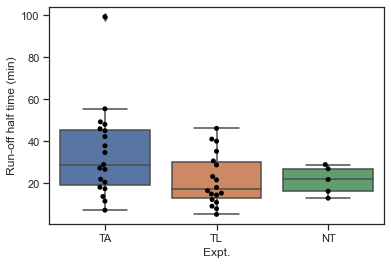

In [290]:
g1=sns.boxplot(y='Run-off half time (min)', x = 'Expt.', data=half_time_df)
g1=sns.swarmplot(y='Run-off half time (min)', x = 'Expt.', data=half_time_df, 
                 palette=['black','black','black']) 

### Save some final plots for publication

[[2.54349706 0.39126082 0.31898002]]


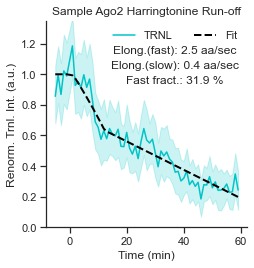

In [153]:
sns.set_style("ticks")
i=2    #3,6,14 other options
temp_df =df_all[(df_all['File']==my_files[i]) & (df_all['Time (min)'])]
temp_data = temp_df.groupby('Time (min)').agg('mean')[rchs[1]]
pars = df_fits[df_fits['File']==my_files[i]][['Fast elong. rate (aa/sec)',
            'Slow elong. rate (aa/sec)','Fast fraction']].values
x_vals = temp_data.index                    
g=sns.relplot(x="Time (min)", y=rchs[1],kind='line', 
            data=temp_df, color=(0,0.77,0.78),legend=False,aspect=1,height=3.5)#,ci=None)
plt.plot(x_vals, myf(x_vals,pars[0][0]*60,pars[0][1]*60,pars[0][2]), linestyle='--', linewidth=2, color='black')
g.set(ylim=(0, 1.35))
print(pars)
plt.title('Sample Ago2 Harringtonine Run-off')
plt.legend(('TRNL','Fit'),loc='upper right',ncol=2, frameon=False)
plt.figtext(0.66, 0.82,  'Elong.(fast): ' + str(np.round(pars[0][0],1) ) + ' aa/sec', 
            wrap=True, horizontalalignment='center')
plt.figtext(0.66, 0.76,  'Elong.(slow): ' + str(np.round(pars[0][1],1) ) + ' aa/sec', 
            wrap=True, horizontalalignment='center')
plt.figtext(0.66, 0.7,  'Fast fract.: ' + str(np.round(100*pars[0][2],2) ) + ' %', 
            wrap=True, horizontalalignment='center')
plt.savefig('Harringtonine-Rep-Ago2.svg', format = 'svg', dpi=300)
temp_df.to_csv('Eg-Cell-Ago2-Harringtonine-data.csv')

[[3.25477912 0.25501474 0.52688326]]


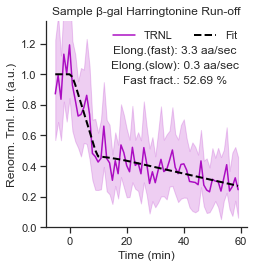

In [154]:
sns.set_style("ticks")
i=26 # 35, 26, 6,14 another option
temp_df =df_all[(df_all['File']==my_files[i])]
temp_data = temp_df.groupby('Time (min)').agg('mean')[rchs[1]]
pars = df_fits[df_fits['File']==my_files[i]][['Fast elong. rate (aa/sec)',
            'Slow elong. rate (aa/sec)','Fast fraction']].values
x_vals = temp_data.index                    
g=sns.relplot(x="Time (min)", y=rchs[1],kind='line', 
            data=temp_df, color=(.67,.05,.76),legend=False,aspect=1,height=3.5)#,ci=None)
plt.plot(x_vals, myf(x_vals,pars[0][0]*60,pars[0][1]*60,pars[0][2]), linestyle='--', linewidth=2, color='black')
g.set(ylim=(0, 1.35))
print(pars)
plt.title('Sample \u03B2-gal Harringtonine Run-off')
plt.legend(('TRNL','Fit'),loc='upper right',ncol=2, frameon=False)
plt.figtext(0.66, 0.82,  'Elong.(fast): ' + str(np.round(pars[0][0],1) ) + ' aa/sec', 
            wrap=True, horizontalalignment='center')
plt.figtext(0.66, 0.76,  'Elong.(slow): ' + str(np.round(pars[0][1],1) ) + ' aa/sec', 
            wrap=True, horizontalalignment='center')
plt.figtext(0.66, 0.7,  'Fast fract.: ' + str(np.round(100*pars[0][2],2) ) + ' %', 
            wrap=True, horizontalalignment='center')
plt.savefig('Harringtonine-Rep-LacZ.svg', format = 'svg', dpi=300)
temp_df.to_csv('Eg-Cell-BetaGal-Harringtonine-data.csv')

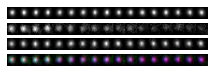

In [119]:
# Calculate the average row through time for the sample LacZ curve
i=2 # corresponds to my_files[i] = 800, which is the 7th TL file tls[7]
my_ta = tas[i]
my_arr = np.ma.masked_equal(my_ta.array_to_crops(my_ta.arr),0)  # convert to N x T crops and mask zeros
my_avg_arr = my_ta.crops_to_array(np.mean(my_arr[:,0::4,:,:,:,:],axis=0))   # take column mean; covert back to crop array  
my_avg_row = np.transpose(my_avg_arr,(1,0,2))       # transpose so shows up as a single row

#Now make figure
minr, maxr, ming, maxg, minb, maxb = 0, 1255, 0, 1000, 0, 1000  # intensity threshholds 
f, axes = plt.subplots(4,1,figsize=(3.6,1.1))  # Create three subplots (4x1 grid)
(c1, c2, c3, comp) = axes.flatten()  # Get the 'handle' for each axes, used for imshow below
c1.imshow(np.clip(my_avg_row[:,:,0],minr,maxr), cmap="gray")
c1.set_axis_off()
c2.imshow(np.clip(my_avg_row[:,:,1],ming,maxg), cmap="gray")
c2.set_axis_off()
c3.imshow(np.clip(my_avg_row[:,:,2],minb,maxb), cmap="gray")
c3.set_axis_off()
rgb = np.moveaxis([
    np.clip(my_avg_row[:,:,0],minr,maxr)/(maxr-minr),
    np.clip(my_avg_row[:,:,1],ming,maxg)/(maxg-ming),
    np.clip(my_avg_row[:,:,2],minb,maxb)/(maxb-minb)],0,-1)
comp.imshow((rgb))  # Expects intensities between 0 and 1
comp.set_axis_off()
plt.savefig('Harringtonine-AvgRow-Ago2.png', format = 'png', dpi=300)

In [ ]:
# Calculate the average row through time for the sample LacZ curve
i = list.index(vids_TL, 'TL04har.tif')
my_ta = tls[i]
my_arr = np.ma.masked_equal(my_ta.array_to_crops(my_ta.arr),0)  # go to N x T crops and ignore zeros
my_avg_arr = my_ta.crops_to_array(np.mean(my_arr[:,0::4,:,:,:,:],axis=0))   # take mean across columms then covert back to crop array  
my_avg_row = np.transpose(my_avg_arr,(1,0,2))       # transpose so shows up as a single crop array row

#Now make figure
minr, maxr, ming, maxg, minb, maxb = 0, 1255, 0, 1000, 0, 600  # intensity threshholds 
f, axes = plt.subplots(4,1,figsize=(3.6,1.1))  # Create three subplots (1x3 grid)
(c1, c2, c3, comp) = axes.flatten()  # Get the 'handle' for each axes, used for imshow below
c1.imshow(np.clip(my_avg_row[:,:,0],minr,maxr), cmap="gray")
c1.set_axis_off()
c2.imshow(np.clip(my_avg_row[:,:,1],ming,maxg), cmap="gray")
c2.set_axis_off()
c3.imshow(np.clip(my_avg_row[:,:,2],minb,maxb), cmap="gray")
c3.set_axis_off()
rgb = np.moveaxis([
    np.clip(my_avg_row[:,:,0],minr,maxr)/(maxr-minr),
    np.clip(my_avg_row[:,:,1],ming,maxg)/(maxg-ming),
    np.clip(my_avg_row[:,:,2],minb,maxb)/(maxb-minb)],0,-1)
comp.imshow((rgb))  # Expects intensities between 0 and 1
comp.set_axis_off()
plt.savefig('Harringtonine-AvgRow-LacZ.png', format = 'png', dpi=300)

In [ ]:
# Let's check that we generate the same curve as above by measuring in the average row image:
# Check that the average row shown by napari above really does correspond to the graphs above:

# Calculate the average row through time for the sample LacZ curve
i = list.index(vids_TL, 'TL04har.tif')
my_ta = tls[i]
my_arr = np.ma.masked_equal(my_ta.array_to_crops(my_ta.arr),0)  # go to N x T crops and ignore zeros
my_avg_arr = my_ta.crops_to_array(np.mean(my_arr,axis=0))   # take mean across columms then covert back to crop array  
my_avg_row = np.transpose(my_avg_arr,(1,0,2))       # transpose so shows up as a single crop array row
#Now make figure
minr, maxr, ming, maxg, minb, maxb = 0, 1255, 0, 1000, 0, 600  # intensity threshholds 
f, axes = plt.subplots(4,1,figsize=(15,1))  # Create three subplots (1x3 grid)
(c1, c2, c3, comp) = axes.flatten()  # Get the 'handle' for each axes, used for imshow below
c1.imshow(np.clip(my_avg_row[:,:,0],minr,maxr), cmap="gray")
c1.set_axis_off()
c2.imshow(np.clip(my_avg_row[:,:,1],ming,maxg), cmap="gray")
c2.set_axis_off()
c3.imshow(np.clip(my_avg_row[:,:,2],minb,maxb), cmap="gray")
c3.set_axis_off()
rgb = np.moveaxis([
    np.clip(my_avg_row[:,:,0],minr,maxr)/(maxr-minr),
    np.clip(my_avg_row[:,:,1],ming,maxg)/(maxg-ming),
    np.clip(my_avg_row[:,:,2],minb,maxb)/(maxb-minb)],0,-1)
comp.imshow((rgb))  # Expects intensities between 0 and 1
comp.set_axis_off()
plt.savefig('Harringtonine-AvgRow-LacZ.png', format = 'png', dpi=300)

In [ ]:
# make mean mask to match the dimensions of a single row
my_mask = np.array([my_ta.disk_mask_2D(3)])   # Make disk mask
my_row_mask = np.transpose(my_ta.crops_to_array(np.mean(my_ta.array_to_crops(my_mask),axis=0)),(1,0,2)) 

In [ ]:
# measure intensity in mask...note it is the same (but without confidence interval cuz it's just a single row!)
row_df = my_ta.measure_intensity_in_mask_df(my_avg_row, my_row_mask, dt=1, start_frame=5, renorm_frames =[0,7])
sns.relplot(x="Time (min)", y="Renorm. Int. Ch. 2 (a.u.)",kind='line', 
            data=row_df,color='darkviolet',legend=False,aspect=1,height=3.5)

In [ ]:
g=sns.relplot(x=rchs[1], y=rchs[2], col="Expt.", hue="Rep.",
            sizes=(40, 80), alpha=.3, palette="bright",
            height=3, data=df_all[df_all['Time (min)']<=0])
g.set(ylim=(0, 30))
g.set(xlim=(-5, 15))

In [ ]:
# Does seem at the beginning of the Harringtonine movies the correlation between the TRNL (Ch1)
# intensity and Ago2 (Ch2, Expt. 0.0) is weaker than between TRNL and LacZ (Ch2, Expt. 1.0)
# This is consistent with the long tracks.Here the data is a bit confusing because many spots 
# have not translation whatsoever (lots of zeros)
sns.lmplot(x=rchs[1], y=rchs[2], col="Expt.",
            palette=["limegreen"],height=4, 
            data=df_all[(df_all['Time (min)']<=0) & (df_all['Expt.']!=2) ]);